# Get QTL peaks

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from Bio import SeqIO
import re

datadir = '/data/leslie/shared/ASA/mouseASA/scripts/human/'
a = SeqIO.index(datadir+'Tcell_NG2018_major.fa','fasta')
b = SeqIO.index(datadir+'Tcell_NG2018_minor.fa','fasta')
ref = SeqIO.index(datadir+'hg19.fa','fasta')

In [2]:
snv = [a[list(a)[i]].description.split(' ')[1] for i in range(len(a))]
chrom = [a[list(a)[i]].id.split(':')[0] for i in range(len(a))]
idx1 = [int(re.split(':|-',a[list(a)[i]].id)[1]) for i in range(len(a))]
idx2 = [int(re.split(':|-',a[list(a)[i]].id)[2]) for i in range(len(a))]

seq = {}
for i in range(1,23):
    seq['chr'+str(i)] = ''.join(ref.get_raw('chr'+str(i)).decode().split('\n')[1:])

peak_seq = []
for i in range(len(a)):
    peak_seq.append(''.join(seq[chrom[i]][idx1[i]:idx2[i]+1].upper()))
    
seqa = [a[list(a)[i]].seq for i in range(len(a))]
seqb = [b[list(b)[i]].seq for i in range(len(b))]

In [3]:
qtl = pd.read_excel(pd.ExcelFile(datadir+'regev_natgen2018_41588_2018_156_MOESM8_ESM.xlsx'),'Sheet1')
qtl = qtl.iloc[:,[0,3]]
qtl_snv = [x.split('_')[1] for x in qtl['SNP']]
idx = []
for i in range(len(snv)):
    if snv[i] in qtl_snv:
        idx.append(qtl_snv.index(snv[i]))
    else:
        idx.append(-1)
idx = np.array(idx)

qtl = qtl.loc[idx[idx!=-1]].reset_index(drop=True)
summits = [int(re.split(':|_',x)[1]) for x in qtl['SNP']]
qtl.head()

/home/sinhaa2/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,SNP,beta
0,chr19:47120381_rs11666367,0.417168
1,chr6:15745394_rs7768219,0.328784
2,chr11:96026842_rs476940,0.355090
3,chr2:112710828_rs4848901,0.394816
4,chr6:32806391_rs4148870,0.309390


In [4]:
peak_minor = []
peak_major = []
mapping = dict(zip(['A','C','G','T','N'],[[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1],[0,0,0,0]]))
for j,i in enumerate(np.where(idx!=-1)[0]):
    variant = list(''.join(seq[chrom[i]][summits[j]-150:summits[j]+150].upper()))
    peak_minor.append(np.asarray([mapping[x] for x in variant]))
    variant[148] = seqa[i][12]
    peak_major.append(np.asarray([mapping[x] for x in ''.join(variant)]))

peak_major = np.asarray(peak_major)
peak_minor = np.asarray(peak_minor)

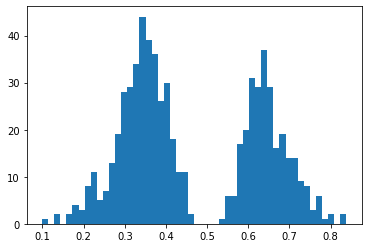

In [5]:
import matplotlib.pyplot as plt
plt.hist(qtl['beta'],bins=50)
plt.show()

## CD8 to Human Transfer

In [27]:
import torch
from model import alleleScan

model = alleleScan(2, 0.2)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

basedir = '/data/leslie/shared/ASA/'
ctype = 'cd8'
dataset = 'both'
use_prior = '1'
gc = ''
modelname = 'm3'
batchsize = '32'
ident = '_vi_150bp'

SAVEPATH = f'{basedir}mouseASA/ckpt_models/{ctype}/{ctype}_{modelname}_{dataset}_{use_prior}_{batchsize}{gc}{ident}.hdf5'
print(SAVEPATH)
model.load_state_dict(torch.load(SAVEPATH))
model.to(DEVICE)
model.eval()
pred_maj = model(torch.from_numpy(peak_major).type(torch.FloatTensor).transpose(1,2).to(DEVICE)).detach().cpu().numpy()
pred_min = model(torch.from_numpy(peak_minor).type(torch.FloatTensor).transpose(1,2).to(DEVICE)).detach().cpu().numpy()

/data/leslie/shared/ASA/mouseASA/ckpt_models/cd8/cd8_m3_both_1_32_vi_150bp.hdf5


In [32]:
import torch
from model import pairScan, pairScanWrapper

model = pairScan(2, 0.2)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

basedir = '/data/leslie/shared/ASA/'
ctype = 'cd8'
dataset = 'both'
use_prior = '1'
gc = ''
modelname = 'ad'
batchsize = '16'
ident = '_vi_150bp'

SAVEPATH = f'{basedir}mouseASA/ckpt_models/{ctype}/{ctype}_{modelname}_{dataset}_{use_prior}_{batchsize}{gc}{ident}_fc.hdf5'
# SAVEPATH = f'{basedir}mouseASA/ckpt_models/{ctype}/test_11.hdf5'
print(SAVEPATH)
model.load_state_dict(torch.load(SAVEPATH))
supermodel = pairScanWrapper(model)
supermodel.to(DEVICE)
supermodel.eval()
temp = np.stack((peak_major, peak_minor), axis=1)
preds = supermodel(torch.from_numpy(temp).type(torch.FloatTensor).transpose(2,3).to(DEVICE)).detach().cpu().numpy().reshape(-1,2)
pred_maj = preds[:,0]
pred_min = preds[:,1]


/data/leslie/shared/ASA/mouseASA/ckpt_models/cd8/cd8_ad_both_1_16_vi_150bp_fc.hdf5


/scratch/lsftmp/17150640.tmpdir/ipykernel_32353/3161023118.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(pred_min, pred_maj,


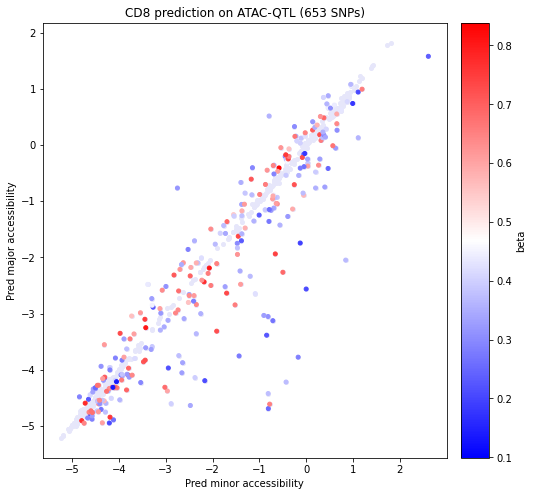

In [33]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
pred_fc = pred_maj-pred_min
true_fc = qtl['beta']

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

ax.scatter(pred_min, pred_maj,
           cmap = 'bwr',s = 16, c = 'lavender')
sc = ax.scatter(pred_min[abs(pred_fc)>0.1],
           pred_maj[abs(pred_fc)>0.1],
            vmax = np.max(qtl['beta']), vmin = np.min(qtl['beta']), cmap = 'bwr',s = 16,
           c = true_fc[abs(pred_fc)>0.1])

plt.title('CD8 prediction on ATAC-QTL ({} SNPs)'.format(len(qtl)))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="7%", pad=0.2,)
fig.colorbar(sc, cax=cax)
ax.set_xlabel('Pred minor accessibility')
ax.set_ylabel('Pred major accessibility')
# ax.set_xlim([2.5,4.5])
# ax.set_ylim([2.5,4.5])
plt.ylabel('beta')
plt.show()